## Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)


Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [160]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Определим функции

In [ ]:
# выводит диаграмму разброса и гистограмму на одном поле
def plot_scat_hist(df, column_x, column_y, hist_bins):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax1, ax2, ax3 = ax.flatten()
    ax1.scatter(df[column_x], df[column_y])
    ax2.hist(df[column_x], bins=hist_bins)
    ax3.hist(df[column_y], bins=hist_bins)
    
    ax1.set_title(f'x = {column_x}, y = {column_y}')
    ax2.set_title(column_x)
    ax3.set_title(column_y)
    
    fig.set_size_inches(20, 7)
    return None

In [148]:
# выводит диаграмму разброса и гистограмму на одном поле
def plot_scat(df, column_x, column_y):
     
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.title('train')
    return None

###  Загружаем данные из файлов

In [134]:
TEST = 'data/test.csv'
TRAIN = 'data/train.csv'

In [135]:
df_test = pd.read_csv(TEST)
df_train = pd.read_csv(TRAIN)

### Посмотрим на содержание признаков

In [136]:
df_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [137]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Избавимся от NaN-ов

#### В дата-сете "df_train" есть признаки с пропущенными значениями, это  колонки "LifeSquare" и "Healthcare_1"


##### Посмотрим на соотношение признаков "LifeSquare" и "Square" 

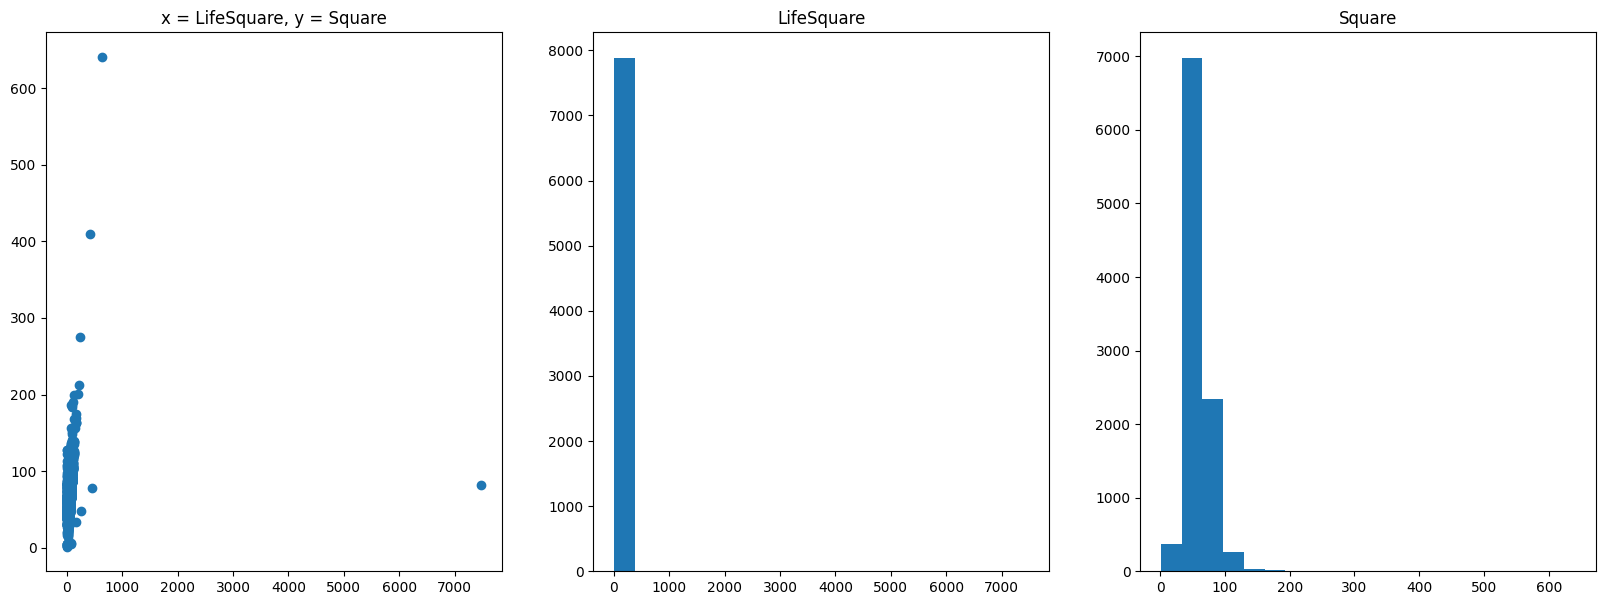

In [138]:
plot_scat_hist(df_train, 'LifeSquare','Square', 20)

#####  Для признака "LifeSquare" есть выбросы, примем за выбросы все значения, которые больше 200 и меньше 10
##### Для признака "Square" так-же есть выбросы, примем за выбросы все значения, которые больше 250 и меньше 10

In [139]:
df_train = df_train[(df_train['LifeSquare'] < 150) & (df_train['LifeSquare'] > 10)]
df_train = df_train[(df_train['Square'] < 175) & (df_train['Square'] > 10)]

##### Еще раз посмотрим на соотношение признаков "LifeSquare" и "Square" 

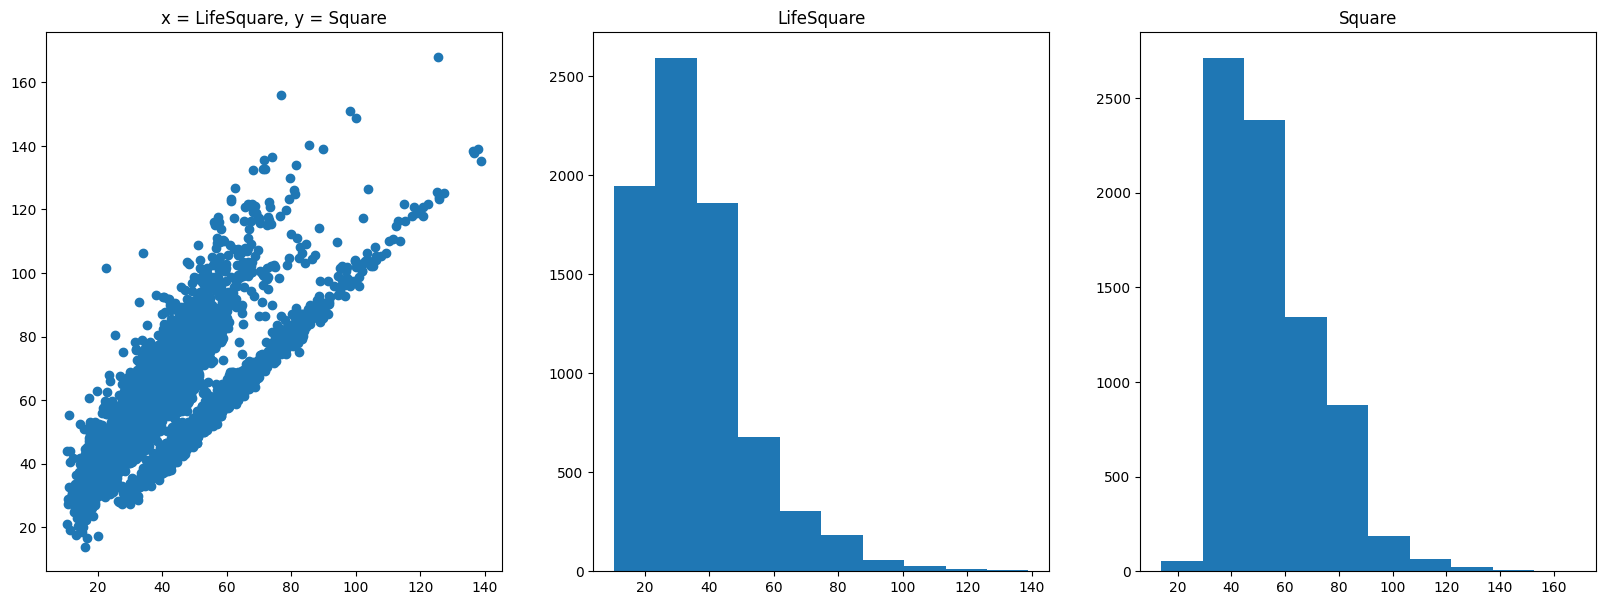

In [141]:
plot_scat_hist(df_train, 'LifeSquare','Square', 10)

##### Посмотрим "поближе" на  соотношение "LifeSquare" и "Square"
##### Попробуем кластеризировать квартиры по соотношениям жилой и полной площади, для того чтобы получить медиану для каждого кластера и заполнить ею недостающие значения

##### Нормализуем значения

In [152]:
scaler = MinMaxScaler()

In [156]:
sq = df_train.loc[:, ['LifeSquare','Square']]
train_scaled = scaler.fit_transform(sq)
train_scaled = pd.DataFrame(train_scaled, columns=['LifeSquare','Square'])


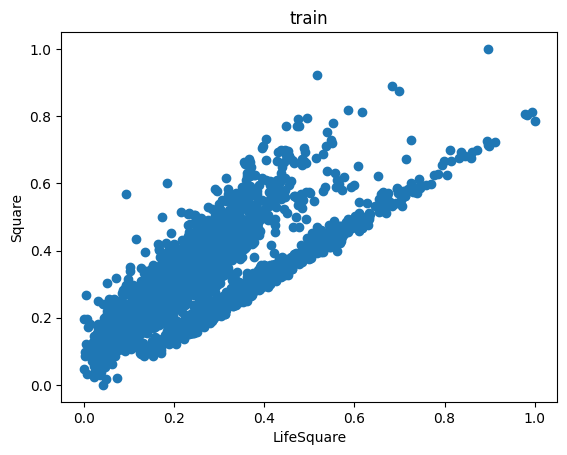

In [157]:
plot_scat(train_scaled, 'LifeSquare','Square')

In [169]:
model = KMeans(n_clusters=4, random_state=100)
train_lables = model.fit_predict(train_scaled)
train_lables

/home/sk/jupyter_projects/gb_Python_DS/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 2, 0, ..., 3, 0, 3], dtype=int32)

##### Координаты центорв кластеров

In [170]:
centers = scaler.inverse_transform(model.cluster_centers_)
centers

array([[34.96484336, 52.273775  ],
       [80.711919  , 94.78094227],
       [50.27787502, 72.60202195],
       [21.92088691, 38.78641081]])

Text(0.5, 1.0, 'train')

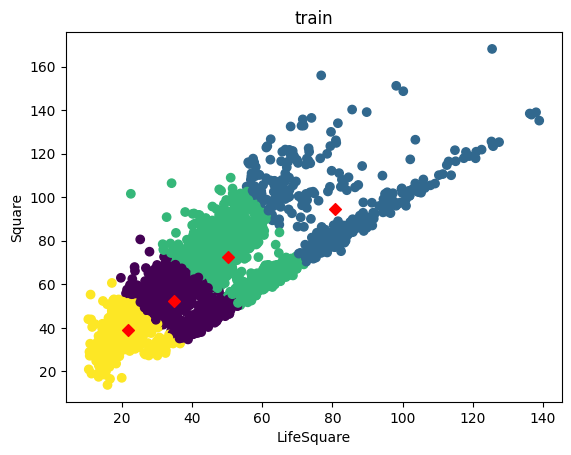

In [171]:
plt.scatter(df_train['LifeSquare'], df_train['Square'], c=train_lables)
plt.scatter(centers[:, 0], centers[:, 1], marker='D', color='red')
#plt.xlim(0, 240)
#plt.ylim(0, 6)
plt.xlabel('LifeSquare')
plt.ylabel('Square')
plt.title('train')